In [1]:
%matplotlib inline
from pymongo import MongoClient
import pandas as pd
from tqdm import *
import pandas as pd
import pylab as p
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import median_absolute_error, mean_squared_error, explained_variance_score, mean_absolute_error, r2_score
from sklearn.cross_validation import ShuffleSplit, train_test_split
import scipy
import random
import time
from multiprocessing import Pool
from scipy.stats import boxcox
import matplotlib
import bayeslite as bl
matplotlib.style.use('ggplot')

In [ ]:
client = MongoClient()
db = client.nba
cursor = db.games.find()
games = []
teams = []
players = []

def str_to_int(val):
    if isinstance(val, int):
        return val
    if len(val.strip()) == 0:
        return 0
    else:
        return int(val.strip())

def str_to_float(val):
    if isinstance(val, float):
        return val
    if len(val.strip()) == 0:
        return 0.0
    else:
        return float(val.strip())    
    
for game_id, document in enumerate(tqdm(cursor)):
    game_dict = {"date":document['date'], 'game_id':game_id}
    games.append(game_dict)
    team_mapping = {}
    for team_id, team in enumerate(document['teams']):
        team_dict = {}
        team_dict['game_id'] = game_id
        team_dict['team_id'] = team['abbreviation']
#         team_dict['abbreviation'] = team['abbreviation']
        team_dict['home'] = team['home']
        team_dict['score'] = int(team['score'])
        team_dict['name'] = team['name']
        team_dict['won'] = team['won']
        team_mapping[team_id] = team['abbreviation']
        teams.append(team_dict)
    for team_id, box in enumerate(document['box']):
        for player in box['players']:
            players_dict = {}
            players_dict['game_id'] = game_id
            players_dict['team_id'] = team_mapping[team_id]
            players_dict['player'] = player['player']
            players_dict['date'] = document['date']
            players_dict['ft_pct'] = str_to_float(player['ft_pct'])
            players_dict['fg3a'] = str_to_int(player['fg3a'])
            players_dict['trb'] = str_to_int(player['trb'])
            players_dict['ft'] = str_to_int(player['ft'])
            players_dict['ast'] = str_to_int(player['ast'])
            players_dict['stl'] = str_to_int(player['stl'])
            players_dict['pts'] = str_to_int(player['pts'])
            players_dict['fg_pct'] = str_to_float(player['fg_pct'])
            players_dict['tov'] = str_to_int(player['tov'])
            players_dict['fg3'] = str_to_int(player['fg3'])
            players_dict['fta'] = str_to_int(player['fta'])
            players_dict['fg3_pct'] = str_to_float(player['fg3_pct'])
            players_dict['pf'] = str_to_int(player['pf'])
            players_dict['mp'] = str_to_int(player['mp'].split(":")[0])*60 + str_to_int(player['mp'].split(":")[1])
            players_dict['blk'] = str_to_int(player['blk'])
            players_dict['fg'] = str_to_int(player['fg'])
            players_dict['drb'] = str_to_int(player['drb'])
            players_dict['orb'] = str_to_int(player['orb'])
            players_dict['fga'] = str_to_int(player['fga'])
            players.append(players_dict)

In [ ]:
players_df = pd.DataFrame(players)
def draft_kings_score(row):
    score = (row['pts']*1.0) + (row['fg3']*0.5) +  (row['trb']*1.25) + (row['ast']*1.5) 
    score += (row['stl']*2.0) + (row['blk']*2.0) + (row['tov']*-0.5)
    doubles = 0
    if row['pts'] > 10:
        doubles += 1
    if row['trb'] > 10:
        doubles += 1
    if row['ast'] > 10:
        doubles += 1
    if row['blk'] > 10:
        doubles += 1
    if row['stl'] > 10:
        doubles += 1
    # double double
    if doubles == 2:
        score += 1.5
    # triple double
    if doubles == 3:
        score + 3
    return score    

players_df['dk_fpts'] = players_df.apply(lambda row:  draft_kings_score(row), axis=1)

player_groups = players_df.groupby('player')
player_min_dates = {}
for name, player_group in player_groups:
    player_min_dates[name] = player_group.date.min()

players_df['year'] = players_df['date'].map(lambda x: x.year)
def get_player_season(row):
    date = row['date']
    min_date = player_min_dates[row['player']]
    diff = date - min_date
    return diff.total_seconds()/3600./24./365.

players_df['years_in_league'] = players_df.apply(lambda row: get_player_season(row), axis=1)

In [ ]:
players_df.to_csv("/Users/jostheimer/workspace/kaggle/data/nba/player_games.csv", index=False, header=True)
games_df = pd.DataFrame(games)
games_df.to_csv("/Users/jostheimer/workspace/kaggle/data/nba/games.csv", index=False, header=True)
teams_df = pd.DataFrame(teams)
teams_df.to_csv("/Users/jostheimer/workspace/kaggle/data/nba/team_games.csv", index=False, header=True)

In [ ]:
teams_df

In [ ]:
# Career numbers for every player
player_career = []

def fill_stats(stat, player_group_stat):
    player_dict = {}
    player_dict["{0}_total".format(stat)] = player_group_stat.sum()
    player_dict["{0}_min".format(stat)] = player_group_stat.min()
    player_dict["{0}_max".format(stat)] = player_group_stat.max()
    player_dict["{0}_mean".format(stat)] = player_group_stat.mean()
    player_dict["{0}_median".format(stat)] = player_group_stat.median()
    player_dict["{0}_std".format(stat)] = player_group_stat.std()
    player_dict["{0}_skewness".format(stat)] = scipy.stats.skew(player_group_stat.values)
    player_dict["{0}_kurtosis".format(stat)] = scipy.stats.kurtosis(player_group_stat.values)
    return player_dict
    
groups = players_df.groupby(by=['player'])
for name, group in groups:
    players_dict = {"player":name}
    players_dict["games_played"] = group.count()
    for col in group.columns:
        if col != "years_in_league" and "date" not in col and "player" not in col and 'team_id' not in col and 'game_id' not in col:
#             print col
            players_dict.update(fill_stats(col, group[col]))
    player_career.append(players_dict)
players_career = pd.DataFrame(player_career)
players_career.to_csv("/Users/jostheimer/workspace/kaggle/data/nba/players_career.csv", index=False, header=True)

In [ ]:
# Team performance for each game
players_df.reset_index(inplace=True)
team_games = []
groups = players_df.groupby(by=['team_id', 'game_id'])
for name, group in groups:
    team_dict = {"team_id":name[0], "game_id":name[1]}
    for col in group.columns:
        if col != "years_in_league" and "date" not in col and "player" not in col and 'team_id' not in col and 'game_id' not in col:
#             print col
            team_dict.update(fill_career_stats(col, group[col]))
    team_games.append(team_dict)
teams_games = pd.DataFrame(team_games)

In [ ]:
drops = []
for col in teams_games.columns:
    if "year" in col:
        drops.append(col)
teams_games.drop(drops, axis=1, inplace=True)
teams_games.to_csv("/Users/jostheimer/workspace/kaggle/data/nba/teams_games.csv", index=False, header=True)

In [ ]:
teams_games = pd.read_csv("/Users/jostheimer/workspace/kaggle/data/nba/teams_games.csv")
teams_games.set_index(['team_id', 'game_id'], inplace=True)
teams_df.reset_index(inplace=True)
teams_df.set_index(['team_id', 'game_id'], inplace=True)
teams_games = teams_games.join(teams_df['home'])

In [ ]:
teams_games

In [ ]:
teams_games.reset_index(inplace=True)
# teams_games.set_index(['team_id', 'game_id'], inplace=True)
teams_games_pivot = teams_games.pivot(index="game_id", columns="home")

In [ ]:
teams_games_pivot

In [ ]:
[' '.join(col).strip() for col in teams_games_pivot.columns.values]

In [2]:
players_df = pd.read_csv("/Users/jostheimer/workspace/kaggle/data/nba/player_games.csv")
teams_games = pd.read_csv("/Users/jostheimer/workspace/kaggle/data/nba/teams_games.csv")
players_career = pd.read_csv("/Users/jostheimer/workspace/kaggle/data/nba/players_career.csv")

players_career.columns = players_career.columns.map(lambda x: ('career_'+ str(x)) if x != "player" and x != "team_id" and x != "game_id" else str(x))

In [3]:
for col in players_career.columns:
    print col

career_ast_kurtosis
career_ast_max
career_ast_mean
career_ast_median
career_ast_min
career_ast_skewness
career_ast_std
career_ast_total
career_blk_kurtosis
career_blk_max
career_blk_mean
career_blk_median
career_blk_min
career_blk_skewness
career_blk_std
career_blk_total
career_dk_fpts_kurtosis
career_dk_fpts_max
career_dk_fpts_mean
career_dk_fpts_median
career_dk_fpts_min
career_dk_fpts_skewness
career_dk_fpts_std
career_dk_fpts_total
career_drb_kurtosis
career_drb_max
career_drb_mean
career_drb_median
career_drb_min
career_drb_skewness
career_drb_std
career_drb_total
career_fg3_kurtosis
career_fg3_max
career_fg3_mean
career_fg3_median
career_fg3_min
career_fg3_pct_kurtosis
career_fg3_pct_max
career_fg3_pct_mean
career_fg3_pct_median
career_fg3_pct_min
career_fg3_pct_skewness
career_fg3_pct_std
career_fg3_pct_total
career_fg3_skewness
career_fg3_std
career_fg3_total
career_fg3a_kurtosis
career_fg3a_max
career_fg3a_mean
career_fg3a_median
career_fg3a_min
career_fg3a_skewness
career_fg3

In [4]:
# players_df = pd.DataFrame.merge(players_df, players_career, how='left', left_on="player", right_on="player")
players_df = players_df.merge(players_career, how='left', left_on="player", right_on="player")

(array([  4.07040000e+04,   7.20620000e+04,   7.97500000e+04,
          7.64590000e+04,   7.47850000e+04,   7.15270000e+04,
          5.90040000e+04,   5.12380000e+04,   3.82040000e+04,
          2.85160000e+04,   2.11280000e+04,   1.32040000e+04,
          8.41700000e+03,   4.37000000e+03,   2.41600000e+03,
          1.26900000e+03,   5.86000000e+02,   2.75000000e+02,
          8.70000000e+01,   5.40000000e+01,   1.80000000e+01,
          6.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  -3. ,    1.6,    6.2,   10.8,   15.4,   20. ,   24.6,   29.2,
          33.8,   38.4,   43. ,   47.6,   52.2,   56.8,   61.4,   66. ,
          70.6,   75.2,   79.8,   84.4,   89. ,   93.6,   98.2,  102.8,
         107.4,  112. ]),
 <a list of 25 Patch objects>)

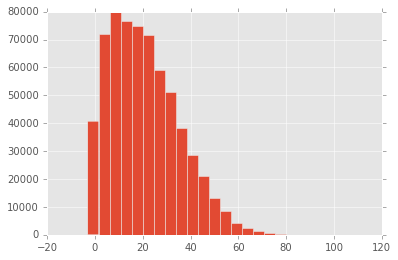

In [5]:
plt.hist(players_df['dk_fpts'].values, bins=25)

In [6]:
players_df

,ast,blk,date,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,career_trb_std,career_trb_total,career_year_kurtosis,career_year_max,career_year_mean,career_year_median,career_year_min,career_year_skewness,career_year_std,career_year_total
0,9,2,1985-10-25 04:00:00,8,8,0,0.000,0,0.533,15,...,5.142789,413,-1.774600,1993,1988.322034,1986,1985,0.344997,3.471265,117311
1,2,1,1985-10-25 04:00:00,7,9,0,0.000,0,0.643,14,...,3.542149,1486,4.002721,1992,1986.839450,1987,1985,1.639011,1.458142,433131
2,4,0,1985-10-25 04:00:00,0,8,0,0.000,2,0.571,14,...,1.434241,206,-1.081362,1987,1986.072727,1986,1985,-0.110162,0.725791,218468
3,1,0,1985-10-25 04:00:00,2,8,0,0.000,0,0.533,15,...,1.851716,2003,-1.106325,1996,1989.974599,1990,1985,0.054662,2.880604,1488501
4,2,4,1985-10-25 04:00:00,6,1,0,0.000,0,0.250,4,...,3.119416,3537,-0.461558,2000,1990.697339,1990,1985,0.718738,4.250791,1795609
5,1,0,1985-10-25 04:00:00,4,0,0,0.000,0,0.000,5,...,3.644960,812,0.111581,1987,1985.817391,1986,1985,-0.198880,0.522857,228369
6,1,0,1985-10-25 04:00:00,0,3,0,0.000,0,0.750,4,...,1.485075,210,-0.747717,1987,1986.132353,1986,1985,-0.151676,0.664539,270114
7,1,0,1985-10-25 04:00:00,0,0,0,0.000,0,0.000,0,...,1.541272,356,-1.008153,1989,1986.954357,1987,1985,-0.038625,1.162787,478856
8,0,0,1985-10-25 04:00:00,2,2,0,0.000,0,0.500,4,...,1.946454,384,-0.550716,1988,1986.578035,1987,1985,-0.216498,0.849749,343678
9,0,0,1985-10-25 04:00:00,0,1,0,0.000,0,0.500,2,...,2.031489,113,-1.644444,1986,1985.642857,1986,1985,-0.596285,0.483494,111196


In [7]:
groups = players_df.groupby(by=['player'])

In [8]:
def get_flattened_columns(prefix, pivot_table):    
    cols = []
    col_dict = {}
    for i, (col, gid) in enumerate(pivot_table.columns.tolist()):
        if gid not in col_dict:
            col_dict[gid] = str(i)
        cols.append(prefix+col_dict[gid]+"_"+col)
    return cols

features = pd.DataFrame()

teams_games = teams_games.sort(['game_id'], ascending=[False])

/Users/jostheimer/virtualenvs/edison_python_2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [ ]:
def get_flattened_columns(prefix, pivot_table):    
    cols = []
    col_dict = {}
    for i, (col, gid) in enumerate(pivot_table.columns.tolist()):
        if gid not in col_dict:
            col_dict[gid] = str(i)
        cols.append(prefix+col_dict[gid]+"_"+col)
    return cols

features = pd.DataFrame()

teams_games = teams_games.sort(['game_id'], ascending=[False])

for name, group in tqdm(groups):
    group = group.sort(['game_id'], ascending=[False])
    try:
        for idx, row in group.iterrows():
            current_fpts = row['dk_fpts']
            groups_lt = group[group['game_id'] < row['game_id']][0:10]
            player = row['player']
            player_career = players_career[players_career['player'] == player]
#             print len(groups_lt)
            if len(groups_lt) >= 10:
                player_games_pivot = groups_lt.pivot(index='player', columns='game_id')
                cols = player_games_pivot.columns.tolist()
                cols = sorted(cols, reverse=True)
                player_games_pivot = player_games_pivot[cols]
                player_games_pivot['current_fpts'] = current_fpts
                pivot = player_games_pivot[['current_fpts', 'dk_fpts', 'year', 'years_in_league']]
                cols = get_flattened_columns("", pivot)
                pivot.columns = cols
                
                # Career stuff
                career_cols = [col for col in player_career.columns if 'dk_fpts' in col]
                for career_col in career_cols:
                    pivot.loc[:, career_col] = pd.Series(player_career[career_col].values[0], index=pivot.index)
                # Other team                
                opposing_team = teams_games[(teams_games['game_id'] == row['game_id']) & (teams_games['team_id'] != row['team_id'])]['team_id'].iloc[0]
                print 'opp team:', opposing_team, 'this team:', row['team_id'], "game_id:", row['game_id']
                
                # games less than this game_id for the opposing team
                opposing_team_previous_game_ids =  teams_games[(teams_games['game_id'] < row['game_id']) & (teams_games['team_id'] == opposing_team)]['game_id'].head(10)
                opposing_team_cols = [col for col in teams_games.columns if 'dk_fpts' in col]
                # find the opposing team to the opposing team
                opposing_team_previous_games = teams_games[(teams_games['game_id'].isin(opposing_team_previous_game_ids)) & (teams_games['team_id'] != opposing_team)]
                # move game_id to the index
                opposing_team_pivot = opposing_team_previous_games.reset_index().pivot_table(columns='game_id', values=opposing_team_cols)
                # unstack so we now have a series game_id to dk_fpts columns
                opposing_team_pivot =  opposing_team_pivot.unstack()
                pivot_new_cols = []
                count = 0
                last_game_id = None
                for l, (game_id, col) in enumerate(opposing_team_pivot.index):
                    if last_game_id is None or last_game_id != game_id:
                        count += 1
                        last_game_id = game_id
                    pivot_new_cols.append("opposing_team_allowed_{1}_{0}_gb".format(count, col))
                # rename the index to flatten the multilevel
                opposing_team_pivot.index = pivot_new_cols
                # convert to dataframe and make the index into columns by transposing
                opposing_team_pivot_t = opposing_team_pivot.to_frame().transpose()
                # setup the transposed index to be for the current player so we can join them
                opposing_team_pivot_t.index = pivot.index
                # finally join the pivoted, transposed opposing team last n games performance
                pivot = pivot.join(opposing_team_pivot_t)
                # final features list has the players last n games performance, career performance, and the team 
                # they are currently playing last N games OPPOSITION performance (how well or poorly has the current
                # team been playing)
                features = pd.concat([features, pivot])
#                 break
    except Exception as e:
        print e
        break
#             print features
#     break

/Users/jostheimer/virtualenvs/edison_python_2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  0%|          | 0/2191 [00:00<?, ?it/s]

opp team: ORL this team: MIA game_id: 17161
opp team: MIL this team: MIA game_id: 17150
opp team: ORL this team: MIA game_id: 17134
opp team: TOR this team: MIA game_id: 17123
opp team: BOS this team: MIA game_id: 17102
opp team: PHI this team: MIA game_id: 17095
opp team: NYK this team: MIA game_id: 17081
opp team: CHH this team: MIA game_id: 17068
opp team: WAS this team: MIA game_id: 17057
opp team: BOS this team: MIA game_id: 17043
opp team: CHI this team: MIA game_id: 17025
opp team: MIL this team: MIA game_id: 17010
opp team: TOR this team: MIA game_id: 16997
opp team: SAS this team: MIA game_id: 16981
opp team: CHI this team: MIA game_id: 16957
opp team: VAN this team: MIA game_id: 16931
opp team: SAC this team: MIA game_id: 16907
opp team: MIN this team: MIA game_id: 16892
opp team: NYK this team: MIA game_id: 16886
opp team: MIN this team: MIA game_id: 16869
opp team: DAL this team: MIA game_id: 16856
opp team: DET this team: MIA game_id: 16839
opp team: CLE this team: MIA gam

/Users/jostheimer/virtualenvs/edison_python_2/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  0%|          | 1/2191 [16:28<601:11:01,  0.00it/s]

 NJN this team: LAL game_id: 127
opp team: PHI this team: WSB game_id: 7164
opp team: ORL this team: WSB game_id: 7153
opp team: NYK this team: WSB game_id: 7137
opp team: CLE this team: WSB game_id: 7121
opp team: MIA this team: WSB game_id: 7111
opp team: NJN this team: WSB game_id: 7096
opp team: MIA this team: WSB game_id: 7083
opp team: CHH this team: WSB game_id: 7068
opp team: DET this team: WSB game_id: 7066
opp team: BOS this team: WSB game_id: 7043
opp team: CHH this team: WSB game_id: 7024
opp team: ATL this team: WSB game_id: 7004
opp team: IND this team: WSB game_id: 7003
opp team: MIL this team: WSB game_id: 6985
opp team: NJN this team: WSB game_id: 6970
opp team: CHI this team: WSB game_id: 6963
opp team: CLE this team: WSB game_id: 6942
opp team: LAL this team: WSB game_id: 6931
opp team: MIN this team: WSB game_id: 6924
opp team: MIA this team: WSB game_id: 6888
opp team: MIL this team: WSB game_id: 6883
opp team: DAL this team: WSB game_id: 6868
opp team: ORL this te

  0%|          | 3/2191 [18:15<96:27:42,  0.01it/s] 

 IND this team: WSB game_id: 5116
opp team: CHI this team: GSW game_id: 18514
opp team: LAC this team: GSW game_id: 18498
opp team: CHH this team: CHI game_id: 18342
opp team: DET this team: CHI game_id: 18313
opp team: PHI this team: CHI game_id: 18191
opp team: ORL this team: CHI game_id: 18178
opp team: ATL this team: CHI game_id: 18152
opp team: POR this team: CHI game_id: 18145
opp team: ATL this team: CHI game_id: 18121
opp team: HOU this team: CHI game_id: 18102
opp team: MIL this team: CHI game_id: 18076
opp team: SAC this team: CHI game_id: 18066
opp team: SAS this team: CHI game_id: 18052
opp team: WAS this team: CHI game_id: 18026
opp team: NJN this team: CHI game_id: 18008
opp team: WAS this team: CHI game_id: 17988
opp team: DET this team: CHI game_id: 17977
opp team: ORL this team: CHI game_id: 17967
opp team: GSW this team: CHI game_id: 17947
opp team: PHO this team: CHI game_id: 17941
opp team: NYK this team: CHI game_id: 17924
opp team: MIA this team: CHI game_id: 1791

  0%|          | 4/2191 [19:09<60:50:00,  0.01it/s]

 SAC this team: CHI game_id: 16143
opp team: CHI this team: WAS game_id: 29254
opp team: BRK this team: WAS game_id: 29239
opp team: PHI this team: WAS game_id: 29226
opp team: MIA this team: WAS game_id: 29210
opp team: NYK this team: WAS game_id: 29199
opp team: BOS this team: WAS game_id: 29182
opp team: IND this team: WAS game_id: 29181
opp team: TOR this team: WAS game_id: 29158
opp team: CHI this team: WAS game_id: 29147
opp team: TOR this team: WAS game_id: 29136
opp team: ORL this team: WAS game_id: 29119
opp team: CLE this team: WAS game_id: 28987
opp team: CHA this team: WAS game_id: 28970
opp team: BRK this team: WAS game_id: 28953
opp team: MIN this team: WAS game_id: 28946
opp team: PHI this team: WAS game_id: 28925
opp team: DET this team: WAS game_id: 28897
opp team: TOR this team: WAS game_id: 28878
opp team: HOU this team: WAS game_id: 28866
opp team: DEN this team: WAS game_id: 28859
opp team: TOR this team: WAS game_id: 28834
opp team: DET this team: WAS game_id: 288

  0%|          | 5/2191 [21:40<67:40:55,  0.01it/s]

 CHI this team: IND game_id: 25031
opp team: DAL this team: HOU game_id: 30486
opp team: NOH this team: HOU game_id: 30472
opp team: GSW this team: HOU game_id: 30446
opp team: SAC this team: HOU game_id: 30441
opp team: ORL this team: HOU game_id: 30421
opp team: POR this team: HOU game_id: 30411
opp team: LAL this team: HOU game_id: 30395
opp team: PHO this team: HOU game_id: 30387
opp team: LAC this team: HOU game_id: 30352
opp team: UTA this team: HOU game_id: 30324
opp team: SAS this team: HOU game_id: 30312
opp team: MIN this team: HOU game_id: 30292
opp team: DET this team: HOU game_id: 30277
opp team: NOH this team: HOU game_id: 30265
opp team: SAS this team: HOU game_id: 30247
opp team: CHA this team: HOU game_id: 30236
opp team: LAL this team: HOU game_id: 30225
opp team: DEN this team: HOU game_id: 30210
opp team: MEM this team: HOU game_id: 30203
opp team: PHO this team: HOU game_id: 30187
opp team: UTA this team: HOU game_id: 30180
opp team: TOR this team: HOU game_id: 301

  0%|          | 7/2191 [25:40<69:06:37,  0.01it/s]

 BOS this team: HOU game_id: 23805
opp team: CHA this team: CHI game_id: 30455
opp team: PHI this team: CHI game_id: 30439
opp team: NYK this team: CHI game_id: 30420
opp team: LAL this team: CHI game_id: 30301
opp team: NOH this team: CHI game_id: 30245
opp team: ORL this team: CHI game_id: 30228
opp team: MIL this team: CHI game_id: 30185
opp team: GSW this team: CHI game_id: 30171
opp team: CHA this team: CHI game_id: 30163
opp team: WAS this team: CHI game_id: 30141
opp team: DEN this team: CHI game_id: 30078
opp team: MIL this team: CHI game_id: 30069
opp team: DAL this team: CHI game_id: 30010
opp team: NOH this team: CHI game_id: 29991
opp team: HOU this team: CHI game_id: 29982
opp team: PHO this team: CHI game_id: 29964
opp team: SAC this team: CHI game_id: 29955
opp team: LAC this team: CHI game_id: 29937
opp team: MIN this team: CHI game_id: 29919
opp team: TOR this team: CHI game_id: 29898
opp team: ATL this team: CHI game_id: 29879
opp team: TOR this team: CHI game_id: 298

  0%|          | 8/2191 [29:08<79:53:13,  0.01it/s]

 LAL this team: CHI game_id: 23710
opp team: ORL this team: PHI game_id: 31681
opp team: IND this team: PHI game_id: 31665
opp team: NJN this team: PHI game_id: 31653
opp team: WAS this team: PHI game_id: 31640
opp team: ATL this team: PHI game_id: 31611
opp team: NYK this team: PHI game_id: 31599
opp team: POR this team: PHI game_id: 31583
opp team: GSW this team: PHI game_id: 31570
opp team: BOS this team: PHI game_id: 31551
opp team: CLE this team: PHI game_id: 31542
opp team: PHO this team: PHI game_id: 31527
opp team: DAL this team: PHI game_id: 31511
opp team: MIA this team: PHI game_id: 31495
opp team: NOH this team: PHI game_id: 31475
opp team: MEM this team: PHI game_id: 31464
opp team: DET this team: PHI game_id: 31452
opp team: NYK this team: PHI game_id: 31440
opp team: CHI this team: PHI game_id: 31412
opp team: MIL this team: PHI game_id: 31410
opp team: CHI this team: PHI game_id: 31395
opp team: SAC this team: PHI game_id: 31380
opp team: NYK this team: PHI game_id: 313

  0%|          | 9/2191 [39:44<104:46:40,  0.01it/s]

 SAC this team: POR game_id: 9859
opp team: BOS this team: GSW game_id: 21295
opp team: BOS this team: GSW game_id: 21236
opp team: NJN this team: GSW game_id: 21232
opp team: TOR this team: GSW game_id: 21220
opp team: CHA this team: GSW game_id: 21110
opp team: SAC this team: GSW game_id: 21098
opp team: NOK this team: GSW game_id: 21083
opp team: TOR this team: GSW game_id: 21072
opp team: UTA this team: GSW game_id: 21068
opp team: SAS this team: GSW game_id: 21047
opp team: NJN this team: GSW game_id: 21034
opp team: LAC this team: GSW game_id: 21029
opp team: POR this team: GSW game_id: 21017
opp team: CHI this team: GSW game_id: 20983
opp team:

  0%|          | 10/2191 [39:56<20:28:15,  0.03it/s]

 PHO this team: GSW game_id: 20975
opp team: MIA this team: NJN game_id: 31678
opp team: ATL this team: NJN game_id: 31657
opp team: PHI this team: NJN game_id: 31653
opp team: IND this team: NJN game_id: 31636
opp team: ORL this team: NJN game_id: 31630
opp team: MIL this team: NJN game_id: 31618
opp team: ATL this team: NJN game_id: 31606
opp team: NYK this team: NJN game_id: 31592
opp team: WAS this team: NJN game_id: 31580
opp team: BOS this team: NJN game_id: 31562
opp team: CLE this team: NJN game_id: 31545
opp team: BOS this team: NJN game_id: 31533
opp team: CHI this team: NJN game_id: 31513
opp team: DAL this team: NJN game_id: 31503
opp team: NYK this team: NJN game_id: 31488
opp team: DET this team: NJN game_id: 31479
opp team: SAC this team: NJN game_id: 31467
opp team: MIA this team: NJN game_id: 31454
opp team: CHI this team: NJN game_id: 31439
opp team: DEN this team: NJN game_id: 31424
opp team: LAL this team: NJN game_id: 31402
opp team: GSW this team: NJN game_id: 313

  1%|          | 12/2191 [49:20<27:47:23,  0.02it/s]

 MIA this team: MIL game_id: 9693
opp team: CHH this team: MIL game_id: 12869
opp team: MIN this team: MIL game_id: 12853
opp team: NJN this team: MIL game_id: 12820
opp team: POR this team: MIL game_id: 12753
opp team: SEA this team: MIL game_id: 12743
opp team: LAL this team: MIL game_id: 12687
opp team: POR this team: MIL game_id: 12645
opp team: CHI this team: MIL game_id: 12517
opp team: IND this team: MIL game_id: 12496
opp team: SAS this team: TOR game_id: 12432
opp team: ATL this team: TOR game_id: 12377
opp team: PHO this team: TOR game_id: 12328
opp team: PHI this team: TOR game_id: 12306
opp team: POR this team: TOR game_id: 12296
opp team: CHI this team: TOR game_id: 12275
opp team: MIA this team: TOR game_id: 12264
opp team: MIN this team: TOR game_id: 12251
opp team: VAN this team: TOR game_id: 12234
opp team: POR this team: TOR game_id: 12217
opp team: SEA this team: TOR game_id: 12205
opp team: ORL this team: TOR game_id: 12184
opp team: NJN this team: TOR game_id: 1217

  1%|          | 13/2191 [51:46<34:58:09,  0.02it/s]

 DET this team: BOS game_id: 8412
opp team: TOR this team: ATL game_id: 30427
opp team: DAL this team: ATL game_id: 30286
opp team: SAC this team: ATL game_id: 30267
opp team: POR this team: ATL game_id: 30251
opp team: IND this team: ATL game_id: 30234
opp team: UTA this team: ATL game_id: 30221
opp team: NOH this team: ATL game_id: 30209
opp team: DET this team: ATL game_id: 30193
opp team: CHA this team: ATL game_id: 30184
opp team: NYK this team: ATL game_id: 30177
opp team: WAS this team: ATL game_id: 30162
opp team: DEN this team: ATL game_id: 30117
opp team: UTA this team: ATL game_id: 30107
opp team: SAC this team: ATL game_id: 30073
opp team: LAL this team: ATL game_id: 30057
opp team: WAS this team: ATL game_id: 30030
opp team: LAC this team: ATL game_id: 30009
opp team: CHA this team: ATL game_id: 30000
opp team: MIN this team: ATL game_id: 29990
opp team: MIL this team: ATL game_id: 29962
opp team: NJN this team: ATL game_id: 29947
opp team: NYK this team: ATL game_id: 2994

  1%|          | 14/2191 [54:08<42:30:54,  0.01it/s]

 MEM this team: ATL game_id: 23635
opp team: HOU this team: DEN game_id: 19533
opp team: LAL this team: DEN game_id: 19527
opp team: PHO this team: DEN game_id: 19425
opp team: WAS this team: DEN game_id: 19408
opp team: HOU this team: DEN game_id: 19405
opp team: DAL this team: DEN game_id: 19364
opp team: PHI this team: DAL game_id: 18819
opp team: LAC this team: DAL game_id: 18806
opp team:

  1%|          | 15/2191 [54:15<11:28:14,  0.05it/s]

 NYK this team: DAL game_id: 18774
opp team: VAN this team: GSW game_id: 17159
opp team: DAL this team: GSW game_id: 17142
opp team: DEN this team: GSW game_id: 17116
opp team: SEA this team: GSW game_id: 17106
opp team: POR this team: GSW game_id: 17097
opp team: SAS this team: GSW game_id: 17080
opp team: POR this team: GSW game_id: 17065
opp team: MIL this team: GSW game_id: 17053
opp team: DET this team: GSW game_id: 17030
opp team: PHI this team: GSW game_id: 17018
opp team: WAS this team: GSW game_id: 17013
opp team: NYK this team: GSW game_id: 16988
opp team: DET this team: GSW game_id: 16977
opp team: WAS this team: GSW game_id: 16955
opp team: SEA this team: GSW game_id: 16936
opp team: LAC this team: GSW game_id: 16921
opp team: UTA this team: GSW game_id: 16906
opp team: HOU this team: GSW game_id: 16878
opp team: DAL this team: GSW game_id: 16865
opp team: LAL this team: GSW game_id: 16846
opp team: LAL this team: GSW game_id: 16833
opp team: POR this team: GSW game_id: 168

  1%|          | 16/2191 [1:02:15<16:06:22,  0.04it/s]

 CLE this team: ATL game_id: 7312
opp team: MEM this team: LAL game_id: 30463
opp team: SAC this team: LAL game_id: 30426
opp team: LAC this team: LAL game_id: 30412
opp team: OKC this team: LAL game_id: 30322
opp team: POR this team: LAL game_id: 30214
opp team: MIN this team: LAL game_id: 30188
opp team: PHO this team: LAL game_id: 30128
opp team: ATL this team: LAL game_id: 30057
opp team: ATL this team: CHA game_id: 30000
opp team: UTA this team: CHA game_id: 29978
opp team: DEN this team: CHA game_id: 29949
opp team: POR this team: CHA game_id: 29944
opp team: LAL this team: CHA game_id: 29929
opp team: IND this team: CHA game_id: 29917
opp team: PHO this team: CHA game_id: 29897
opp team: MEM this team: CHA game_id: 29883
opp team: SAS this team: CHA game_id: 29869
opp team: POR this team: CHA game_id: 29856
opp team: DET this team: CHA game_id: 29826
opp team: WAS this team: CHA game_id: 29811
opp team: CLE this team: CHA game_id: 29782
opp team: BOS this team: CHA game_id: 2977

  1%|          | 17/2191 [1:04:18<21:02:12,  0.03it/s]

 BOS this team: CHA game_id: 22276
opp team: SAC this team: GSW game_id: 31673
opp team: LAL this team: GSW game_id: 31669
opp team: DAL this team: GSW game_id: 31651
opp team: MIN this team: GSW game_id: 31634
opp team: POR this team: GSW game_id: 31626
opp team: HOU this team: GSW game_id: 31615
opp team: CLE this team: GSW game_id: 31597
opp team: BOS this team: GSW game_id: 31584
opp team: TOR this team: GSW game_id: 31578
opp team: PHI this team: GSW game_id: 31570
opp team: LAC this team: GSW game_id: 31552
opp team: WAS this team: GSW game_id: 31535
opp team: MIL this team: GSW game_id: 31521
opp team: LAC this team: GSW game_id: 31500
opp team: HOU this team: GSW game_id: 31484
opp team: ORL this team: GSW game_id: 31472
opp team: SAS this team: GSW game_id: 31459
opp team: NOH this team: GSW game_id: 31446
opp team: SAS this team: GSW game_id: 31443
opp team: UTA this team: GSW game_id: 31430
opp team: SAC this team: GSW game_id: 31418
opp team: MEM this team: GSW game_id: 313

In [ ]:
features

In [ ]:
features.to_csv("/Users/jostheimer/workspace/kaggle/data/nba/features_10.csv")

In [ ]:
features_save = features.copy(deep=True)

In [ ]:
features = pd.read_csv("/Users/jostheimer/workspace/kaggle/data/nba/features_10.csv", index_col=[0])

In [ ]:
if '0_current_fpts' in features.columns:
    targets = features['0_current_fpts']
    features = features.drop(['0_current_fpts'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=42)

# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

cfr = ExtraTreesRegressor(
    oob_score = True, bootstrap=True, verbose = 1, max_features = len(features.columns), n_estimators = 10000, min_samples_leaf = 1,
    n_jobs=8,
    random_state=0,
)
cfr.fit(x_train, y_train)



In [ ]:
predictions = cfr.predict(x_test)
x_test['prediction'] = predictions
# predictions = inverse_box_cox(predictions,lambda_, min_target)
plt.scatter(y_test, predictions)
plt.show()
print "mean_absolute_error", mean_absolute_error(y_test, predictions)
print "mean_squared_error", mean_squared_error(y_test, predictions)
print "explained_variance", explained_variance_score(y_test, predictions)
print "median_absolute_error", median_absolute_error(y_test, predictions)
print "r2_score", r2_score(y_test, predictions)

In [ ]:
print "Features sorted by their score:"
sorted_features =  sorted(zip(map(lambda x: round(x, 4), cfr.feature_importances_), x_train.columns), 
             reverse=True)
for sorted_feat in sorted_features:
    print sorted_feat

In [ ]:
from notebook.auth import passwd
passwd()